In [1]:
import time

import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import plotly.io as pio

layout = {
    'showlegend': True,
    'margin': {'b':10, 'l':20, 'r':50, 't':50},
    'font': {'size': 19},
    'xaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'yaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'template': 'plotly_white',
}
pio.renderers.default = "png"
px.defaults.color_discrete_sequence = px.colors.qualitative.D3

%load_ext autoreload
%autoreload 2

# Input data
-----------------------------
We use [SimBench](https://simbench.de/en/download/datasets/) to obtain a representative low voltage network
We use the [Quoilin](https://github.com/squoilin/Self-Consumption/releases) database for household consumption in France
We use the [PVGIS](https://re.jrc.ec.europa.eu/pvg_tools/en/) database for solar irradiation in Lyon

In [2]:
from moopf import scenario

# Network, active profiles, reactive profiles, active net loads, battery specs
net, dfp, dfq, df, batteries = scenario.get_network_and_timeseries()

Max loading = 114.908
Transformator eq. impedance (secondary) = (0.015+0.037j) Ohm (x1).


![./results/SimBench grid with text.png](results/SimBench%20grid%20with%20text.png)

# Pareto
---------------------------------

In [3]:
import logging

# Logging info
log_filename = "logs/tradeoff_individual_reduc.log"
logger = logging.getLogger("Tradeoff")
logger.setLevel('DEBUG')
file_handler = logging.FileHandler(log_filename, mode="w")
if not len(logger.handlers):
    logger.addHandler(file_handler)

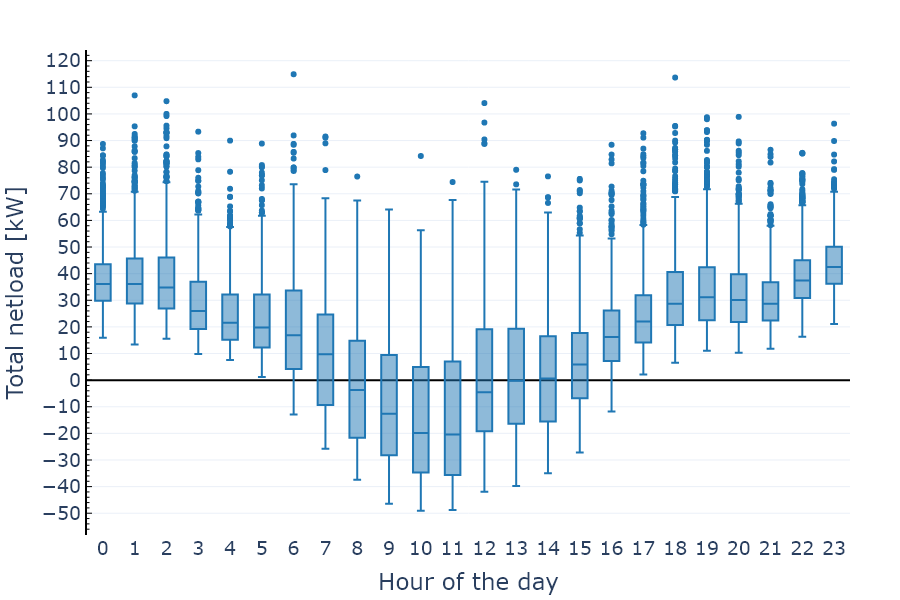

In [4]:
# Horizon 2 days starting at 5 AM (cause sliding does not guarantee bounds and solutions have the same initial conditions)
graph = df.sum(axis=1).copy().to_frame("netload")
graph["hour"] = graph.index.hour

fig = px.box(graph, y="netload", x="hour")
#fig.add_vline(x=5, line_color="red", line_dash="dash", line_width=4, opacity=0.5)
fig.update_layout(layout, xaxis_dtick=1, height=600, width=900)
fig.update_layout(xaxis_title="Hour of the day", yaxis_title="Total netload [kW]")
fig.update_layout(yaxis_dtick=10, yaxis_minor_ticks="inside", yaxis_minor_ticklen=2.5, xaxis_zeroline=False)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(ticklen=5, tickcolor='black', ticks="inside")
fig.show()
fig.write_image("results/netload_data.svg")

In [5]:
from moopf import tradeoff
from datetime import timedelta

with open(log_filename, 'w'):
    pass

days = 2
starts = pd.date_range(datetime(2019, 1, 1, 5, 0, 0), periods=182, freq=f"{days}D")
durations = [slice(start, start + timedelta(days=days) - timedelta(minutes=15)) for start in starts]
assert durations[-1].stop in df.index
p_kw = df.loc[durations[0].start:durations[-1].stop, :].copy()
q_kvar = dfq.loc[durations[0].start:durations[-1].stop, :].copy()

study = tradeoff.Tradeoff()
study.remove_efficiency_for = [datetime(2019, 4, 27, 5, 0, 0),
                               datetime(2019, 4, 29, 5, 0, 0),
                               datetime(2019, 10, 4, 5, 0, 0),
                               datetime(2019, 10, 18, 5, 0, 0),
                               datetime(2019, 10, 20, 5, 0, 0),
                               datetime(2019, 10, 22, 5, 0, 0),
                               datetime(2019, 10, 28, 5, 0, 0),
                               datetime(2019, 10, 30, 5, 0, 0),
                               datetime(2019, 11, 1, 5, 0, 0),
                               datetime(2019, 11, 15, 5, 0, 0),
                               datetime(2019, 11, 17, 5, 0, 0),
                               datetime(2019, 11, 25, 5, 0, 0),
                               datetime(2019, 12, 27, 5, 0, 0)]
study.lower_battery_capacity_by = 0.86
study.lower_battery_power_by = 0.8
study.solve(durations, net, p_kw, q_kvar, {i:dict(batteries) for i in df.columns}, _options={"complement_tolerance": 1})

import pickle
with open('results/tradeoff_ind_reduc.pickle', 'wb') as handle:
    pickle.dump(study, handle, protocol=pickle.HIGHEST_PROTOCOL)

Progress: 100%|██████████| 182/182 [3:09:07<00:00, 62.35s/it]  


In [3]:
import pickle
with open('results/tradeoff_ind_reduc.pickle', 'rb') as handle:
    study = pickle.load(handle)

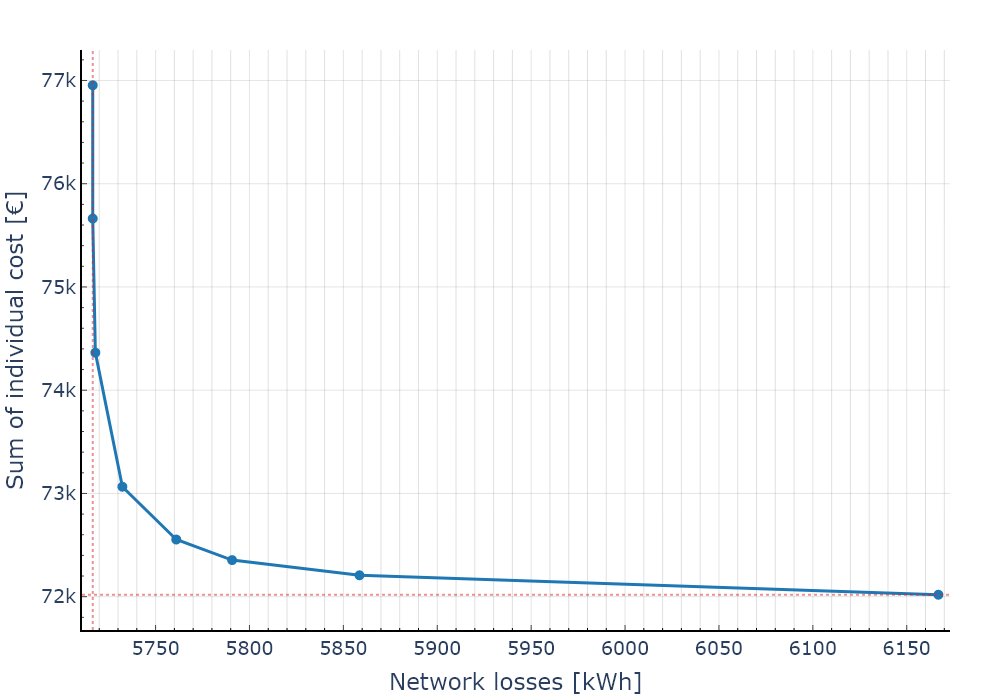

In [7]:
graph = study.summary.copy()
fig = px.line(graph, x="total_losses", y="actual_cost")
fig.data[0].update(mode="markers+lines")
fig.data[0].update(line_width=3, marker_size=10)

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='rgba(127, 127, 127, 0.2)')
fig.update_xaxes(minor=dict(ticks="inside", ticklen=2, tickcolor="black", showgrid=True), ticks="inside", ticklen=5)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='rgba(127, 127, 127, 0.2)')
fig.update_yaxes(minor_ticks="inside", minor_ticklen=2, ticks="inside", ticklen=5)

fig.add_vline(x=fig.data[0].x[-1], line_dash="dot", opacity=0.5, line_color='#d62728')
fig.add_hline(y=fig.data[0].y[0], line_dash="dot", opacity=0.5, line_color='#d62728')

fig.update_layout(
    layout,
    height=700,
    width=1000,
    showlegend=False,
    yaxis_title="Sum of individual cost [€]",
    xaxis_range=[(1 - 1e-3) * graph.total_losses.min(), (1 + 1e-3) * graph.total_losses.max()],
    xaxis_title="Network losses [kWh]",
)

fig.show()
fig.write_image("results/tradeoff_ind_reduc.svg")

In [8]:
study.summary

,actual_cost,total_losses,vm_above_percent,vm_below_percent,vm_square_error,max_upper_demand,max_back_feed
0,72018.713876,6166.866416,0.0,1.602564,0.309900,64.790565,-13.025926
1,72207.100230,5858.581528,0.0,0.489354,0.319520,47.832053,-5.852711
2,72354.443610,5790.743749,0.0,0.291896,0.311233,45.002266,-5.734542
3,72553.550345,5761.008131,0.0,0.183150,0.307819,43.027103,-5.726667
4,73064.986277,5732.320424,0.0,0.080128,0.304378,40.122388,-5.712875
5,74363.824438,5717.925497,0.0,0.065820,0.302398,36.573879,-5.665955
6,75662.662599,5716.530338,0.0,0.068681,0.302107,35.837879,-5.643180
7,76953.805380,5716.532758,0.0,0.068681,0.302094,35.810998,-5.642806


In [23]:
df_metric = pd.DataFrame(index=range(0, study.nb_tradeoffs + 2))
for i, result in enumerate(study.results):
    df_metric.loc[i, "actual_cost"] = result.loc[:, "actual_cost"].sum()
    df_metric.loc[i, "total_losses"] = result.loc[:, "total_losses"].sum()
    df_metric.loc[i, "vm_above_percent"] = result.loc[:, "vm_above_percent"].quantile(0.95)  # 5% of simulations --> 6 * 3j = 18j included
    df_metric.loc[i, "vm_below_percent"] = result.loc[:, "vm_below_percent"].quantile(0.95)
    # df_metric.loc[i, "vm_square_error"] = result.loc[:, "vm_square_error"].sum()
    df_metric.loc[i, "max_upper_demand"] = result.loc[:, "max_upper_demand"].quantile(0.95)
    df_metric.loc[i, "max_back_feed"] = result.loc[:, "max_back_feed"].quantile(0.05)
df_metric[["actual_cost", "total_losses", "vm_below_percent", "max_upper_demand", "max_back_feed"]].round(1)

,actual_cost,total_losses,vm_below_percent,max_upper_demand,max_back_feed
0,72018.7,6166.9,5.7,96.2,-29.7
1,72207.1,5858.6,1.6,87.6,-16.8
2,72354.4,5790.7,1.0,75.0,-16.8
3,72553.6,5761.0,0.5,69.2,-16.8
4,73065.0,5732.3,0.5,66.3,-16.8
5,74363.8,5717.9,0.5,62.4,-16.7
6,75662.7,5716.5,0.5,60.1,-16.6
7,76953.8,5716.5,0.5,59.9,-16.6


In [26]:
_ = df_metric.copy()
print(f"trade-off #2 cost achievement = "
      f"{(1 - (_.at[2, 'actual_cost']-_.at[0, 'actual_cost'])/(_.at[7, 'actual_cost'] - _.at[0, 'actual_cost'])) * 100:0.2f}%")
print(f"trade-off #2 loss achievement = "
      f"{(1 - (_.at[2, 'total_losses']-_.at[7, 'total_losses'])/(_.at[0, 'total_losses'] - _.at[7, 'total_losses'])) * 100:0.2f}%")

trade-off #2 cost achievement = 93.20%
trade-off #2 loss achievement = 83.52%


In [28]:
print(f"trade-off #1 loss achievement = "
      f"{(1 - (_.at[1, 'total_losses']-0)/(_.at[0, 'total_losses'] - 0)) * 100:0.2f}%")

trade-off #1 loss achievement = 5.00%


In [10]:
for _ in range(study.nb_tradeoffs + 2):
    mask = study.results[_].remove_battery_efficiency == False
    print(f"Split# {_} with efficiency = "
          f"{study.results[_][mask].remove_battery_efficiency.count() * 100 / len(study.results[_]):0.2f}%")

Split# 0 with efficiency = 100.00%
Split# 1 with efficiency = 47.25%
Split# 2 with efficiency = 47.25%
Split# 3 with efficiency = 47.25%
Split# 4 with efficiency = 47.25%
Split# 5 with efficiency = 47.25%
Split# 6 with efficiency = 47.25%
Split# 7 with efficiency = 47.25%


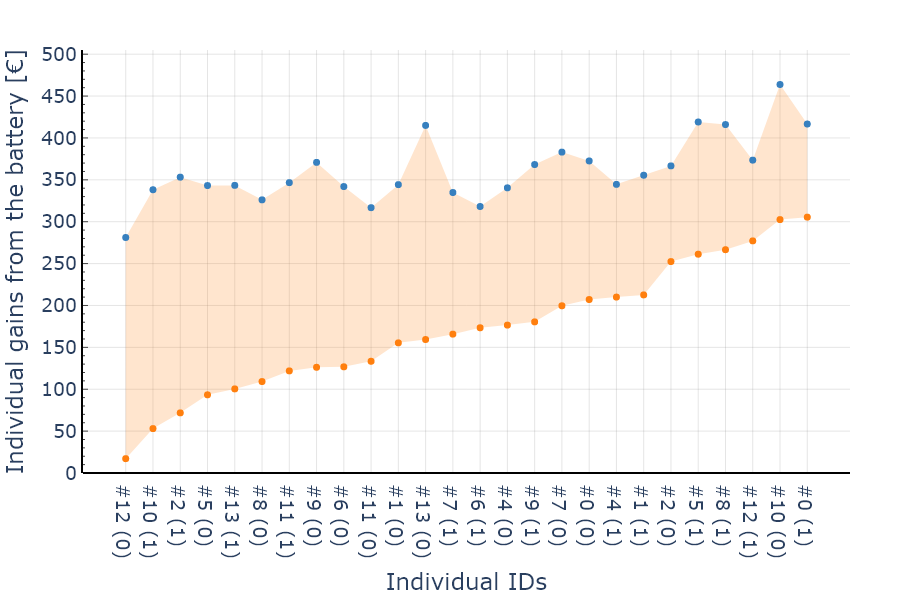

In [29]:
from moopf.losses import OptimizeLosses

def get_cost_without_batteries(_df, start, stop):
    _ = OptimizeLosses()
    _original_cost = pd.Series()
    for col in _df.columns:
        cost = (_df.loc[start:stop, col].clip(lower=0).sum() * _.grid_buy
              - _df.loc[start:stop, col].clip(upper=0).abs().sum() * _.grid_sell) / (60 / _.freq)
        _original_cost.loc[str(f"#{col}")] = cost
    return _original_cost.to_frame("no batt")
original_cost = get_cost_without_batteries(df, study.durations[0].start, study.durations[-1].stop)

ind_costs = original_cost.copy()
for tradeoff in range(study.nb_tradeoffs + 2):
    temp = study.individual_costs[tradeoff].sum(axis=0).to_frame(tradeoff)  # Total per participant for each trade-off
    temp.index = [str(f"#{ind}") for ind in temp.index]  # Change name of participant ??
    ind_costs = pd.concat([ind_costs, temp], axis=1)

graph = -1 * ind_costs.sub(ind_costs["no batt"], axis=0).sort_values(study.nb_tradeoffs+1, ascending=False)
cols = [graph.columns[1], graph.columns[-1]]
graph["x"] = [word.replace("#", "#").replace(".", " (") + ')' for word in graph.index.to_list()]

fig = px.line(graph, x="x", y=cols)
fig.update_traces(line_width=0, mode="lines+markers", marker_size=7)
fig.data[0].update(marker_color="rgba(55, 128, 191, 1.0)", marker_symbol="0")
fig.data[-1].update(fill="tonexty", fillcolor="rgba(255, 127, 14, 0.2)", marker_symbol="0",
                    marker_color="rgba(255, 127, 14, 1.0)")
fig.update_layout(layout, yaxis_title="Individual gains from the battery [€]",
                  xaxis_title="Individual IDs", height=600, width=900, showlegend=False)

fig.update_xaxes(showline=False, linewidth=2, linecolor='black', gridcolor='rgba(127, 127, 127, 0.2)')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='rgba(127, 127, 127, 0.2)', dtick=50)
fig.update_yaxes(minor_ticks="inside", minor_ticklen=2, ticks="inside", ticklen=5, range=[0, 505])

#fig.add_hline(y=graph[graph.columns[1]].mean(), line_dash="dash", line_color="rgba(55, 128, 191, 1.0)", line_width=3, opacity=0.6)

fig.show()
fig.write_image("results/sharing_ind_reduc.svg")

In [9]:
ind_costs

,no batt,0,1,2,3,4,5,6,7
#9.0,2915.719510,2544.883797,2550.522947,2553.196623,2559.37708,2588.447117,2665.814635,2725.522932,2789.5214
#7.0,2843.540823,2460.452595,2473.775343,2474.064193,2474.484185,2477.252429,2522.48119,2612.906631,2643.902557
#13.0,3925.530994,3510.588721,3520.654256,3530.135833,3543.841879,3587.481388,3671.195275,3714.539657,3766.170808
#12.0,3631.149146,3350.001534,3354.781873,3359.863358,3370.987743,3407.130056,3496.520347,3539.146563,3614.033483
#8.0,2853.746151,2527.638663,2538.11816,2539.665052,2544.890205,2559.815343,2630.167193,2694.534446,2744.568166
#5.0,3542.382847,3199.198344,3210.915367,3236.881506,3269.496634,3327.928908,3371.798659,3406.068583,3449.030863
#2.0,4049.110958,3682.45145,3689.435469,3701.682976,3713.261771,3728.918208,3748.820091,3768.609001,3796.698379
#0.0,2970.371150,2597.82509,2608.943569,2613.995925,2625.254659,2659.890461,2699.553312,2720.003806,2763.274388
#6.0,3236.441490,2894.467525,2900.664716,2905.469632,2912.529612,2930.965455,2981.672703,3032.535831,3109.686355
#11.0,3409.941426,3093.184602,3086.244031,3090.85646,3097.926855,3114.142264,3161.724389,3224.517407,3276.554874


In [30]:
graph[graph.columns[1]].mean()

361.29560023741044

In [33]:
graph[graph.columns[-2]].max()

305.4303562742052

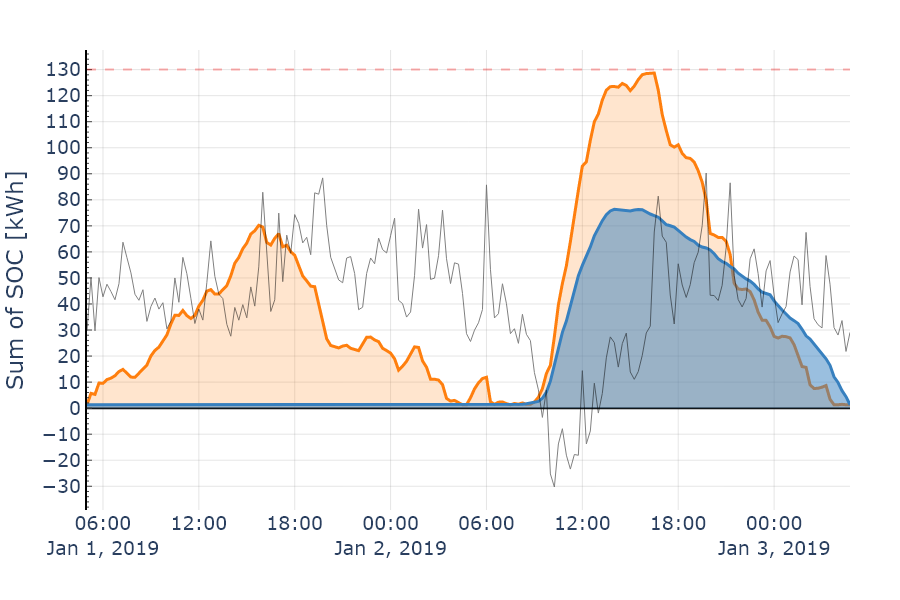

In [12]:
period = 0
cost_schedule= study.instances[0][period]
loss_schedule = study.instances[study.nb_tradeoffs+1][period]

graph = loss_schedule["battery_energy"].sum(axis=1).to_frame("min. loss")
graph["min. cost"] = cost_schedule["battery_energy"].sum(axis=1)
graph["unctrl"] = df.loc[durations[period].start:durations[period].stop, :].sum(axis=1)

fig = px.line(graph)
fig.update_traces(line_width=3)
fig.data[1].update(fill="tozeroy", fillcolor="rgba(55, 128, 191, 0.5)", line_color="rgba(55, 128, 191, 1.0)")
fig.data[0].update(fill="tozeroy", fillcolor="rgba(255, 127, 14, 0.2)", line_color="rgba(255, 127, 14, 1.0)")
fig.data[-1].update(line_width=1, line_color="black", opacity=0.5)

fig.update_layout(layout, showlegend=False, width=900, height=600)
fig.update_yaxes(title="Sum of SOC [kWh]")
fig.update_xaxes(title="")

fig.update_xaxes(showline=False, linewidth=2, linecolor='black', gridcolor='rgba(127, 127, 127, 0.2)')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='rgba(127, 127, 127, 0.2)', dtick=10)
fig.update_yaxes(minor_ticks="inside", minor_ticklen=2, ticks="inside", ticklen=5)

fig.add_hline(y=13 * 2 * 5, line_dash="dash", line_color="red", opacity=0.3)
fig.show()
fig.write_image("results/timeseries_ind_reduc.svg")

In [13]:
study.results[0].iloc[0]

actual_cost                  814.601623
total_losses                  85.845595
vm_above_percent                    0.0
vm_below_percent              23.958333
vm_square_error                 1.03233
max_upper_demand              91.058786
max_back_feed                 -1.183301
remove_battery_efficiency           0.0
Name: 2019-01-01 05:00:00, dtype: object

In [14]:
study.results[-1].iloc[0]

actual_cost                  841.647023
total_losses                  82.166068
vm_above_percent                    0.0
vm_below_percent               2.604167
vm_square_error                1.088271
max_upper_demand              61.986434
max_back_feed                       0.0
remove_battery_efficiency           0.0
Name: 2019-01-01 05:00:00, dtype: object